## Exploratory Data Analysis

### Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

### Read in Data

In [2]:
crimes_byday = pd.read_csv('../data/crimes_byday.csv', index_col = 0, parse_dates = True)

In [3]:
crimes_byday.index.freq='D'

### Data Visualization - All Crimes

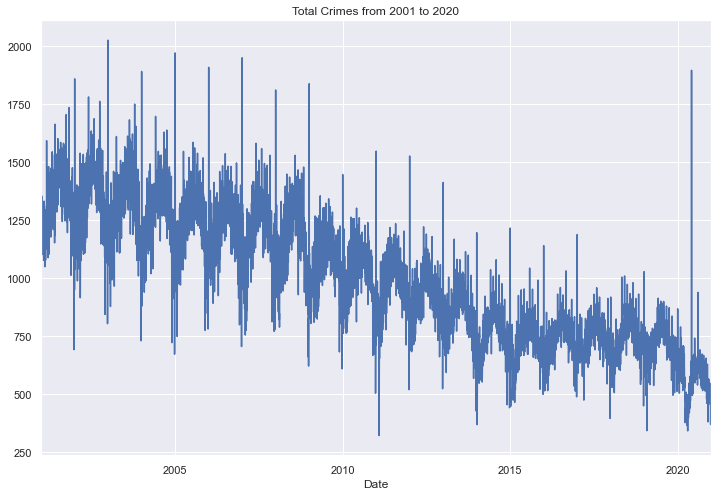

In [4]:
crimes_byday['Total Crimes'].plot(figsize=(12,8))
plt.title('Total Crimes from 2001 to 2020');

We can see from the plot that there is strong annual seasonality as well as a downward trend.  The trend does not appear to be exponential (although it's not quite linear either) and so we'll try both an additive model and multiplicative model for our smoothing algorithm.  In addition there seem to be large spikes on a yearly basis.  We also see a spike this past year, presumably during the time of the riots in the summer.  Let's try to to decompose this and see what we've got. 

### Seasonal Decomposition

In [5]:
decomp = seasonal_decompose(crimes_byday['Total Crimes'], period=365, model = 'add')

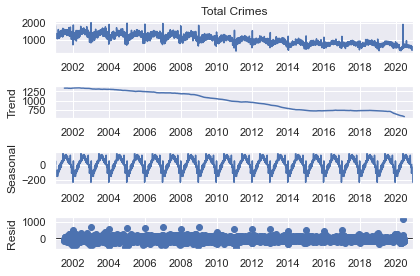

In [6]:
decomp.plot();

We can see the strong annual seasonal component. Let's try multiplicative.  

In [7]:
decomp = seasonal_decompose(crimes_byday['Total Crimes'], period=365, model = 'mul')

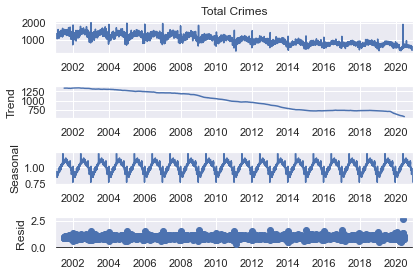

In [8]:
decomp.plot();

Interesting.  The multiplicative model tends to capture the yearly spikes as part of the seasonal component, whereas the additive model didn't, and had a much larger residual.  For this reason, it probably makes sense to use a multiplicative model, although we can try both.   

I also imagine there is a weekly component as well, so let's just look at the last three months.  

In [9]:
decomp = seasonal_decompose(crimes_byday['Total Crimes'].loc['2020-10-01':], period=7, model = 'add')

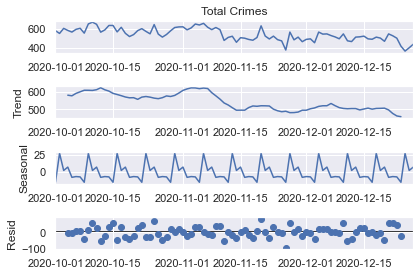

In [10]:
decomp.plot();

So we can see that there is a weekly seasonal component, but it isn't as strong as I would have imagined.  

Let's investigate these spikes a bit further.  We'll blow up just the first five years.  

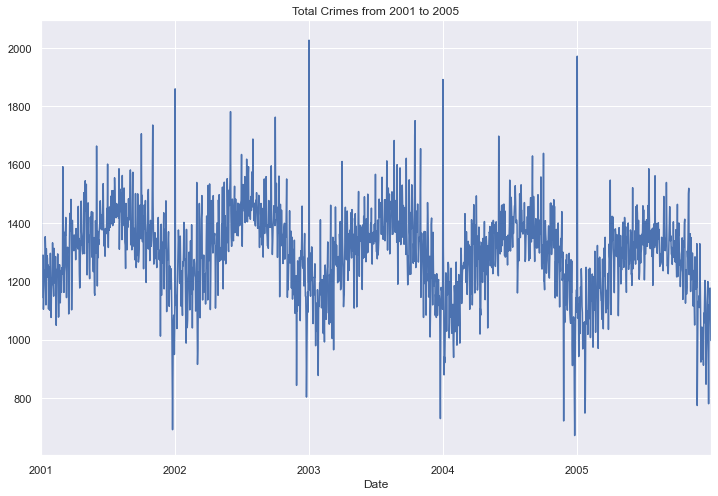

In [11]:
crimes_byday['Total Crimes'].loc['2001-01-01':'2005-12-31'].plot(figsize=(12,8))
plt.title('Total Crimes from 2001 to 2005');

So we see clearly that crimes are generaly higher in the summer and lower in the winter.  There also appears to be a sharp decrease right around the holidays followed by a short spike right on New Year's Day. Let's investigate this further.  

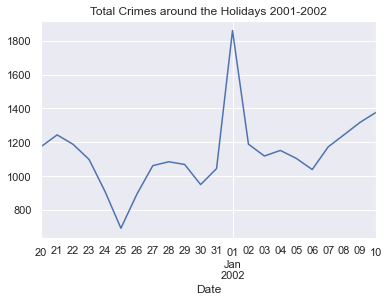

In [12]:
crimes_byday['Total Crimes'].loc['2001-12-20':'2002-01-10'].plot(figsize=(6,4))
plt.title('Total Crimes around the Holidays 2001-2002');

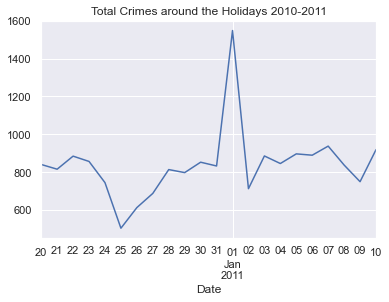

In [13]:
crimes_byday['Total Crimes'].loc['2010-12-20':'2011-01-10'].plot(figsize=(6,4))
plt.title('Total Crimes around the Holidays 2010-2011');

So we're definitely seeing a pattern here.  Crimes are very low on Christmas Day, then gradually increase and then there's a big spike on New Year's Day (presumably in the early morning hours).  Interesting!  

Let's also look at the big spike last summer.  

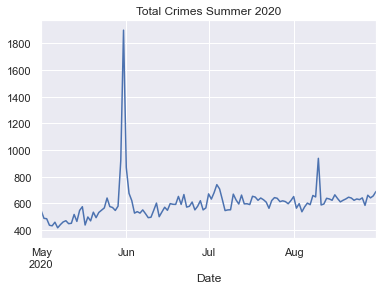

In [14]:
crimes_byday['Total Crimes'].loc['2020-05-01':'2020-08-31'].plot(figsize=(6,4))
plt.title('Total Crimes Summer 2020');

I've researched the dates of the looting in Chicago.  June 1st as well as August 9th and 10th were very violent days, so this corresponds to what we're seeing. 

Let's generate a nice visual so we can see the seasonality of the data more clearly.  

In [15]:
crimes_byday['Month'] = crimes_byday.index.strftime('%B')

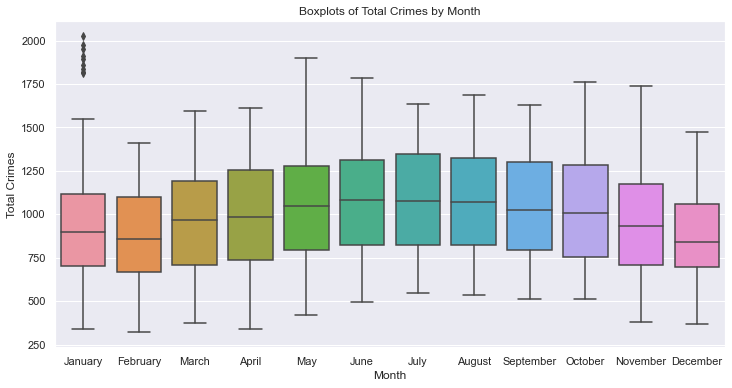

In [16]:
plt.figure(figsize=(12, 6))
plt.title('Boxplots of Total Crimes by Month')
sns.boxplot(data=crimes_byday, x='Month', y = 'Total Crimes');

Here we can see that crimes are higher in the summer months, and lower in the winter aside from January which is pushed higher due to the large spike on New Year's Day (we can see outliers in January as well).  

### Plot ACF and PACF

Let's plot the ACF and PACF for one year's worth of data.  

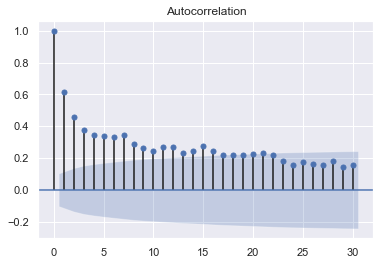

In [17]:
plot_acf(crimes_byday['Total Crimes'].loc['2020-01-01':], lags=30);

Notice the strong positive autocorrelation or momentum shown by crime data.  

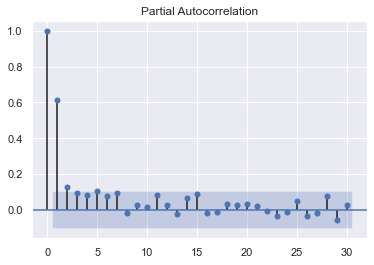

In [18]:
plot_pacf(crimes_byday['Total Crimes'].loc['2020-01-01':], lags=30);

Looking at the above two graphs, we see that the PACF graph drops off quickly after 1 lag, and the ACF decreases gradually.  This suggests that we can model the time series with a strictly AR(1) process.  Note: I'm not clear about this because what about differencing?  We need to difference to make proecss stationary.  

In [19]:
diff_total_crimes = crimes_byday['Total Crimes'].diff(periods=365)
diff_total_crimes.dropna(inplace=True)

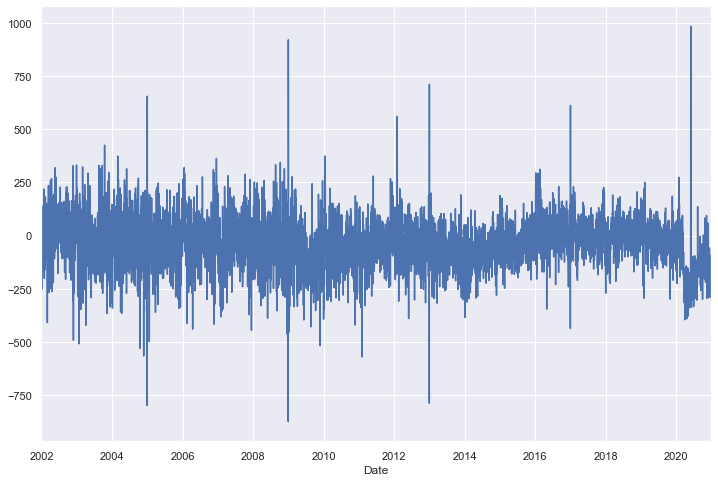

In [20]:
diff_total_crimes.plot(figsize=(12,8));

This still doesn't look quite stationary becuase it seems the variance is decreasing over time.  Let's check with ADFuller test.

In [21]:
adfuller(diff_total_crimes)

(-7.687503135491772,
 1.4484423669720586e-11,
 35,
 6900,
 {'1%': -3.4312980774524684,
  '5%': -2.861958973110752,
  '10%': -2.566993015521949},
 83044.01204717765)

The ADFuller test shows a very small p-value, so we can reject the null hypothesis and conclude that our differenced time series is stationary.  Let's plot the ACF and PACF again.  

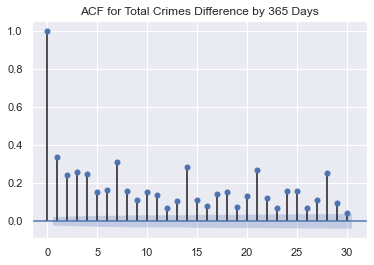

In [22]:
plot_acf(diff_total_crimes, lags=30)
plt.title('ACF for Total Crimes Difference by 365 Days');

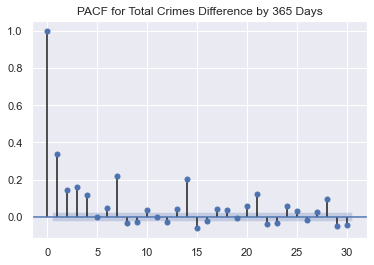

In [23]:
plot_pacf(diff_total_crimes, lags=30)
plt.title('PACF for Total Crimes Difference by 365 Days');

I'm confused about how to interpret these now. We're still seeing strong positive auto correlation and partial auto-correlation and now it's not clear that the model looks like either a pure AR or pure MA model.  

### Data Visualization - Crime Categories

Now let's plot categories of crimes, which will consist of everything except "Total Crimes", "Arrest", and "Domestic" (since those all contain the other categories).  

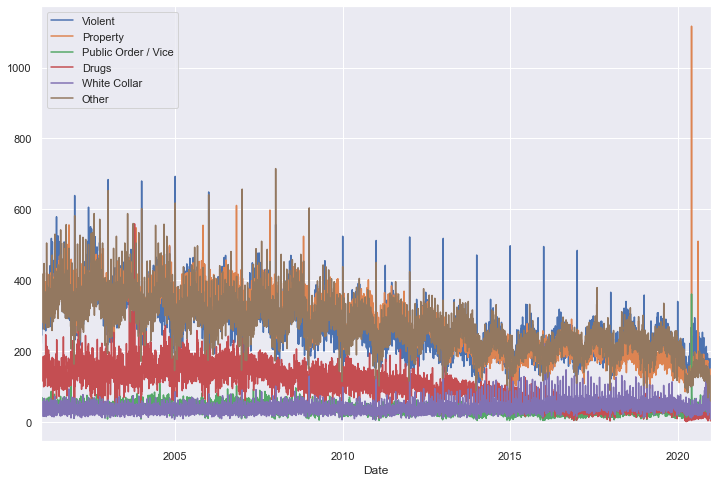

In [24]:
crime_groups = crimes_byday.columns[3:]

crimes_byday[crime_groups].plot(figsize=(12,8),legend=True);

Let's zoom in on 2020.

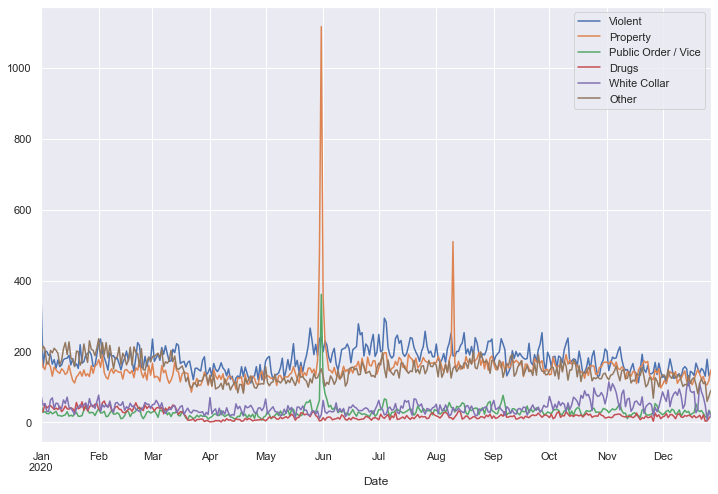

In [25]:
crimes_byday[crime_groups].loc['2020-01-01':].plot(figsize=(12,8),legend=True);

### Data Visualization - Arrests and Domestic Incidents

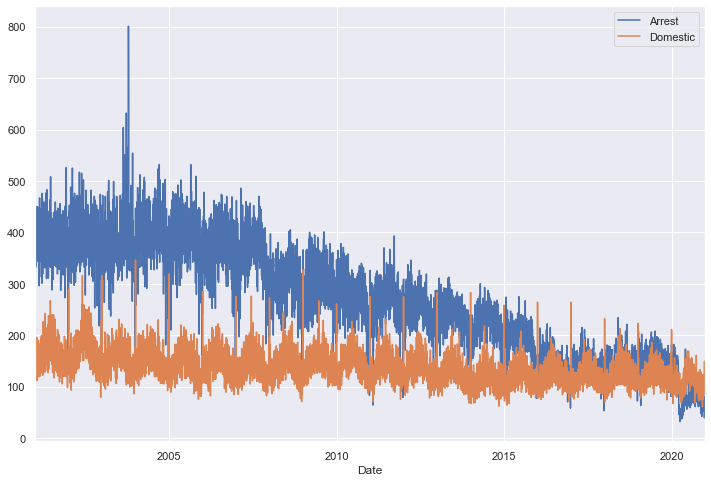

In [26]:
crimes_byday[['Arrest','Domestic']].plot(figsize=(12,8));

That's interesting.  Arrests have shown a downward trend, whereas domestic crimes have not shown the same trend.  And domestic crimes tend to have a strong seasonality to them and that large spike on New Year's Day, whereas arrests don't show that.  

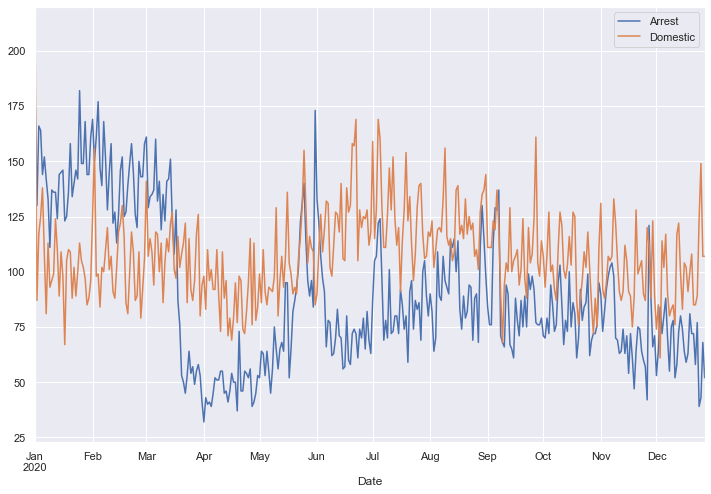

In [27]:
crimes_byday[['Arrest','Domestic']].loc['2020-01-01':].plot(figsize=(12,8));